<a href="https://colab.research.google.com/github/vujjiniashrith/IOT_security/blob/main/Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset and preprocessing it

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


***Import the entire dataset and remove the nan values***

In [ ]:
df = pd.read_excel("combined_dataset.xlsx")

In [ ]:
columns = df.columns
print(columns)
columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM']
df.drop(columns=columns_to_delete, inplace=True)
print(df.columns)

Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3', 'INOP_PLETH',
       'INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM'],
      dtype='object')
Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3'], dtype='object')


In [ ]:
df.shape

(87879, 7)

<AxesSubplot:>

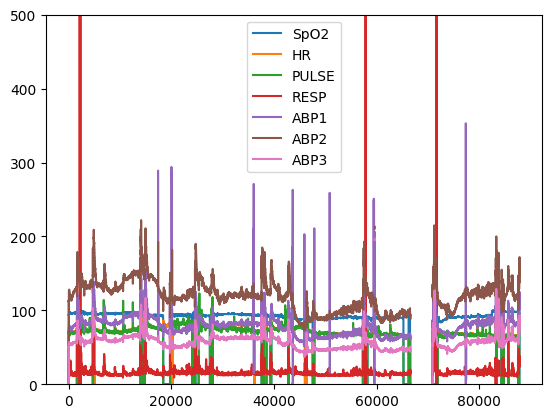

In [ ]:
df.plot(ylim=(0, 500), kind='line')

<AxesSubplot:>

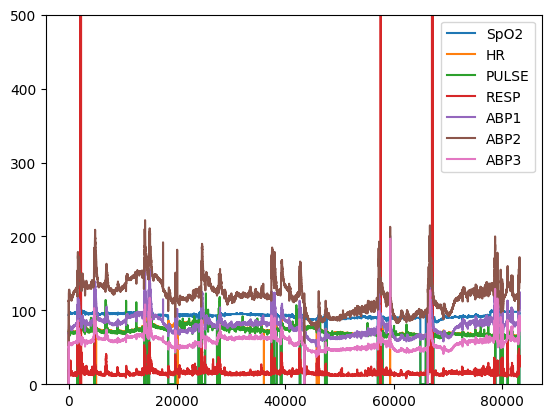

In [ ]:
df.dropna( inplace = True)
df.reset_index(drop = True, inplace = True)
df.plot(ylim=(0, 500), kind='line')

<AxesSubplot:>

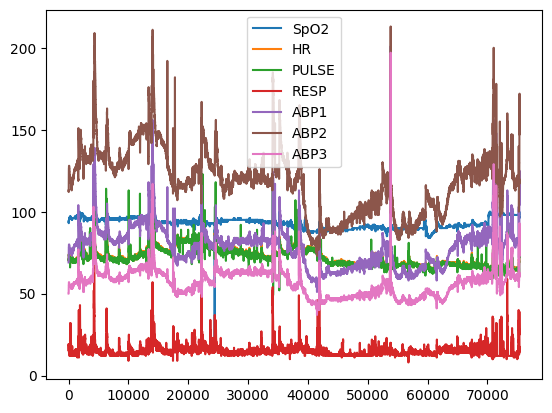

In [ ]:
df = df.loc[(df != 0).all(axis=1)]
df.reset_index(drop = True, inplace = True)
df.plot(kind='line')

***Split the dataset into train and test and normalize***

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data = df.values

In [ ]:
print(data.shape)
print(len(data)*0.8)

(75380, 7)
60304.0


In [ ]:
train = data[:60304]
test = data[60304:]

In [ ]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

In [ ]:
train = scaler_train.fit_transform(train)
test = scaler_test.fit_transform(test)

***Adding noise to the dataset for testing***

In [ ]:
def add_salt_and_pepper_noise_7d(data, salt_prob, pepper_prob):
    noisy_data = np.copy(data)
    num_samples, num_dimensions = data.shape

    # Add salt noise
    salt_points = int(num_samples * salt_prob)
    salt_indices = np.random.choice(num_samples, salt_points, replace=False)
    noisy_data[salt_indices, :] = np.max(data, axis=0)

    # Add pepper noise
    pepper_points = int(num_samples * pepper_prob)
    pepper_indices = np.random.choice(num_samples, pepper_points, replace=False)
    noisy_data[pepper_indices, :] = np.min(data, axis=0)

    return noisy_data

In [ ]:
test_noisy= add_salt_and_pepper_noise_7d(test, 0.01,0.01)


In [ ]:
df_test_noisy = pd.DataFrame(test_noisy, columns=df.columns)

<AxesSubplot:>

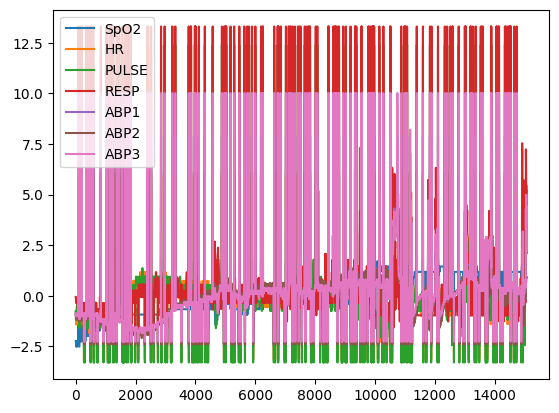

In [ ]:
df_test_noisy.plot()

In [ ]:
lookback = 128
reshaped_train = []
reshaped_test= []
reshaped_test_noisy=[]

for i in range(len(train)-lookback+1):
    sample_train = train[i:i+lookback]
    reshaped_train.append(sample_train)
reshaped_train = np.array(reshaped_train)


for i in range(len(test)-lookback+1):
    sample_test = test[i:i+lookback]
    reshaped_test.append(sample_test)
reshaped_test = np.array(reshaped_test)

for i in range(len(test_noisy)-lookback+1):
    sample_test_noisy = test_noisy[i:i+lookback]
    reshaped_test_noisy.append(sample_test_noisy)
reshaped_test_noisy = np.array(reshaped_test_noisy)

***Using tensorflow split the dataset into batches***

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(reshaped_train)
test_data = tf.data.Dataset.from_tensor_slices(reshaped_test)
test_data_noisy = tf.data.Dataset.from_tensor_slices(reshaped_test_noisy)

2023-11-01 10:18:07.360692: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 10:18:07.379933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 10:18:07.380082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-01 10:18:07.381086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
train_data = train_data.batch(128)
test_data = test_data.batch(128)
test_data_noisy = test_data_noisy.batch(128)

In [ ]:
test_data = test_data.shuffle(10000)

In [ ]:
dataiterator = train_data.as_numpy_iterator()

In [ ]:
dataiterator.next().shape

(128, 128, 7)

# Build Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten , Reshape, LeakyReLU, Dropout, UpSampling1D,Conv2D

***Generator***

In [ ]:
def build_generator():
    model = Sequential()

    #we give 16 random inputs to generate a sequence of (128,7) output
    model.add(Dense(16*7, input_dim = 16))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16,7)))

    #Upsampling block 1
    model.add(UpSampling1D())#effectively doubles the each row and column
    model.add(Conv1D(14,5,padding = 'same'))# total 128 filters with shape 5x5
    model.add(LeakyReLU(0.2))

    #Upsampling block 2
    model.add(UpSampling1D())
    model.add(Conv1D(28,5,padding='same'))
    model.add(LeakyReLU(0.2))

    #Upsampling block 3
    model.add(UpSampling1D())#effectively doubles the each row and column
    model.add(Conv1D(14,5,padding = 'same'))# total 128 filters with shape 5x5
    model.add(LeakyReLU(0.2))

    #Convlutional bloc 1
    model.add(Conv1D(7,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv1D(7,4,padding = 'same', activation = 'sigmoid'))

    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               1904      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112)               0         
                                                                 
 reshape (Reshape)           (None, 16, 7)             0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 32, 7)            0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 32, 14)            504       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 14)            0         
                                                        

In [ ]:
imgs = generator.predict(np.random.randn(4,16))

2023-11-01 10:18:09.050719: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-01 10:18:09.141634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
2023-11-01 10:18:09.428328: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
imgs.shape

(4, 128, 7)

***Build Discriminator***

In [ ]:
def build_discriminator():
    model = Sequential()

    #first conv block
    model.add(Conv1D(28,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second conv block
    model.add(Conv1D(56,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #third conv block
    model.add(Conv1D(75,5,2,input_shape = (128,7)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))


    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation = 'sigmoid'))



    return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 62, 28)            1008      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 62, 28)            0         
                                                                 
 dropout (Dropout)           (None, 62, 28)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 29, 56)            7896      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 29, 56)            0         
                                                                 
 dropout_1 (Dropout)         (None, 29, 56)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 13, 75)           

In [ ]:
discriminator.predict(imgs)

array([[0.50545365],
       [0.5086061 ],
       [0.5074253 ],
       [0.50724596]], dtype=float32)

# Building Custom Training Loop

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

In [ ]:
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

***Build Subclassed Model***

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class WBAN_GAN(Model):
    def __init__(self, generator,discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        #create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        self.latent_vectors = []

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        #compile with the base class
        super().compile(*args, **kwargs)

        #create attribute for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss


    def train_step(self,batch):

        #get the data
        real_data = batch
        random_latent = tf.random.normal((128,16,1))
        fake_data = self.generator(random_latent, training = False)

        # Store the latent vectors
        self.latent_vectors.append(random_latent)

        #train the dicriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_data , training = True)
            yhat_fake = self.discriminator(fake_data, training = True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis = 0)

            #Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            #add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real,noise_fake],axis=0)

            #calculate loss
            total_d_loss = self.d_loss(y_realfake,yhat_realfake)

        #Apply backpropogation - nn learn
        dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))


        #train the generator
        with tf.GradientTape() as g_tape:
            #Generate new data to trick the discriminator
            gen_data = self.generator(tf.random.normal((128,16,1)), training = True)

            #Create the predicted labels
            predicted_labels = self.discriminator(gen_data,training = False)

            #calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels)

        #apply backpropogation
        ggrad = g_tape.gradient(total_g_loss,self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

        return {"d_loss" : total_d_loss, "g_loss": total_g_loss}

    def get_latent_vector(self):
        return self.latent_vectors


In [ ]:
wbanGAN = WBAN_GAN(generator,discriminator)

In [ ]:
wbanGAN.compile(g_opt,d_opt,g_loss,d_loss)

In [ ]:
hist =wbanGAN.fit(train_data,epochs= 400)

Epoch 1/400
471/471 [==============================] - 6s 9ms/step - d_loss: 0.6542 - g_loss: 0.7200
Epoch 2/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.6341 - g_loss: 0.7045
Epoch 3/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.5940 - g_loss: 0.7195
Epoch 4/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.5995 - g_loss: 0.7395
Epoch 5/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.6220 - g_loss: 0.7262
Epoch 6/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.5767 - g_loss: 0.7668
Epoch 7/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.5548 - g_loss: 0.8266
Epoch 8/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.4962 - g_loss: 1.2036
Epoch 9/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.4868 - g_loss: 1.4732
Epoch 10/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.4790 - g_lo

471/471 [==============================] - 4s 9ms/step - d_loss: 0.3725 - g_loss: 2.1452
Epoch 82/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3587 - g_loss: 2.3024
Epoch 83/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3476 - g_loss: 2.4382
Epoch 84/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3406 - g_loss: 2.5414
Epoch 85/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3353 - g_loss: 2.6266
Epoch 86/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3325 - g_loss: 2.6835
Epoch 87/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3285 - g_loss: 2.7078
Epoch 88/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3254 - g_loss: 2.7537
Epoch 89/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3226 - g_loss: 2.7971
Epoch 90/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3201 - g_loss: 

471/471 [==============================] - 5s 10ms/step - d_loss: 0.3791 - g_loss: 1.8459
Epoch 161/400
471/471 [==============================] - 4s 10ms/step - d_loss: 0.5645 - g_loss: 1.3568
Epoch 162/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3863 - g_loss: 2.2730
Epoch 163/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3573 - g_loss: 2.6532
Epoch 164/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3456 - g_loss: 2.7577
Epoch 165/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3547 - g_loss: 2.3215
Epoch 166/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.4606 - g_loss: 1.7273
Epoch 167/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.3718 - g_loss: 2.3326
Epoch 168/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3523 - g_loss: 2.2594
Epoch 169/400
471/471 [==============================] - 4s 9ms/step - d_loss: 0.354

471/471 [==============================] - 5s 10ms/step - d_loss: 0.3194 - g_loss: 2.9470
Epoch 240/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3157 - g_loss: 2.7941
Epoch 241/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3108 - g_loss: 2.8928
Epoch 242/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3056 - g_loss: 2.9397
Epoch 243/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3020 - g_loss: 2.9696
Epoch 244/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2994 - g_loss: 2.9796
Epoch 245/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3238 - g_loss: 2.6489
Epoch 246/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3759 - g_loss: 2.1244
Epoch 247/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3771 - g_loss: 2.5803
Epoch 248/400
471/471 [==============================] - 5s 10ms/step - d_loss

Epoch 318/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3699 - g_loss: 2.3226
Epoch 319/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3490 - g_loss: 2.7724
Epoch 320/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3097 - g_loss: 3.1645
Epoch 321/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2994 - g_loss: 3.3351
Epoch 322/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2951 - g_loss: 3.4316
Epoch 323/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2920 - g_loss: 3.5171
Epoch 324/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3155 - g_loss: 2.8668
Epoch 325/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.3034 - g_loss: 2.9946
Epoch 326/400
471/471 [==============================] - 4s 10ms/step - d_loss: 0.2929 - g_loss: 3.0902
Epoch 327/400
471/471 [==============================] - 5s 10ms

471/471 [==============================] - 5s 10ms/step - d_loss: 0.2850 - g_loss: 2.5883
Epoch 397/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2872 - g_loss: 2.6059
Epoch 398/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2815 - g_loss: 2.7563
Epoch 399/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2803 - g_loss: 2.7970
Epoch 400/400
471/471 [==============================] - 5s 10ms/step - d_loss: 0.2798 - g_loss: 2.8119


In [ ]:
generator.save_weights('generator_400iter.h5')

In [ ]:
discriminator.save_weights('discriminator_400iter.h5')

In [ ]:
#discriminator.load_weights('discriminator1.h5')

***Using discriminator to find any data attacks***

In [ ]:
predicted_labels = discriminator.predict(train_data)
predicted_labels_test = discriminator.predict(test_data)
predicted_labels_test_noisy = discriminator.predict(test_data_noisy)

In [ ]:
test_predictions = [1 if value > 0.4 else 0 for value in predicted_labels_test]
test_predictions_noisy = [1 if value > 0.5 else 0 for value in predicted_labels_test_noisy]

In [ ]:
print(test_predictions.count(1))
print(test_predictions_noisy.count(1))

0
0


In [ ]:
train_predictions = [1 if value > 0.5  else 0 for value in predicted_labels]

In [ ]:
total_ones = train_predictions.count(1)
total_ones

0

In [ ]:
test

array([[-2.24530702, -0.98191467, -0.7508837 , ..., -0.90469597,
        -0.8781322 , -0.86907167],
       [-2.24530702, -0.98191467, -0.7508837 , ..., -1.00943481,
        -0.8781322 , -0.86907167],
       [-2.24530702, -0.98191467, -1.17500878, ..., -1.00943481,
        -0.8781322 , -0.86907167],
       ...,
       [ 0.9190316 ,  5.04270274,  5.18686748, ...,  4.43698484,
         3.75124235,  4.2967756 ],
       [ 0.9190316 ,  5.04270274,  5.18686748, ...,  4.12276833,
         3.52356819,  4.01754061],
       [ 0.9190316 ,  5.04270274,  5.18686748, ...,  3.80855181,
         3.22000265,  3.59868813]])

In [ ]:
train_original = scaler_train.inverse_transform(train)
test_original = scaler_test.inverse_transform(test)
test_original_noisy = scaler_test.inverse_transform(test_noisy)

In [ ]:
train_original

array([[ 94.,  71.,  71., ...,  69., 113.,  50.],
       [ 94.,  71.,  71., ...,  69., 113.,  50.],
       [ 94.,  71.,  71., ...,  70., 113.,  51.],
       ...,
       [ 85.,  65.,  65., ...,  72., 109.,  51.],
       [ 85.,  65.,  65., ...,  72., 109.,  51.],
       [ 85.,  65.,  65., ...,  72., 109.,  51.]])

In [ ]:
test_original

array([[ 85.,  65.,  65., ...,  72., 108.,  51.],
       [ 85.,  65.,  65., ...,  71., 108.,  51.],
       [ 85.,  65.,  64., ...,  71., 108.,  51.],
       ...,
       [ 97.,  79.,  79., ..., 123., 169.,  88.],
       [ 97.,  79.,  79., ..., 120., 166.,  86.],
       [ 97.,  79.,  79., ..., 117., 162.,  83.]])

In [ ]:
train_df = pd.DataFrame(train_original,columns=df.columns)
test_df = pd.DataFrame(test_original,columns=df.columns)
test_df_noisy = pd.DataFrame(test_original_noisy, columns=df.columns)

In [ ]:
test_df.head()

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,85.0,65.0,65.0,15.0,72.0,108.0,51.0
1,85.0,65.0,65.0,15.0,71.0,108.0,51.0
2,85.0,65.0,64.0,15.0,71.0,108.0,51.0
3,85.0,65.0,64.0,15.0,71.0,108.0,51.0
4,85.0,65.0,64.0,15.0,71.0,107.0,51.0


In [ ]:
len(train_predictions)


60177

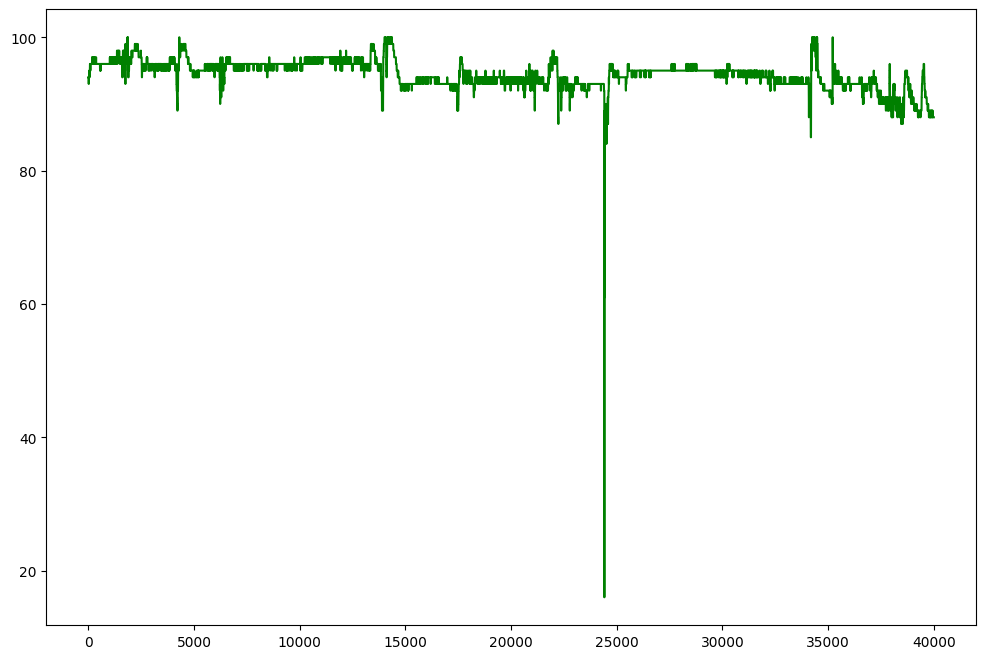

In [ ]:
plt.figure(figsize=(12, 8))
normal_x = []  # X-coordinates for normal data
normal_y = []  # Y-coordinates for normal data

anomaly_x = []  # X-coordinates for anomalies
anomaly_y = []  # Y-coordinates for anomalies

for i, score in enumerate(train_predictions[:40000]):
    if score == 1:
        # Anomaly data
        anomaly_x.append(i)
        anomaly_y.append(train_df['SpO2'].iloc[i])

        # Normal data
    normal_x.append(i)
    normal_y.append(train_df['SpO2'].iloc[i])
plt.plot(normal_x, normal_y, color='g', label='Normal')

# Plot anomalies as a red dot
plt.scatter(anomaly_x, anomaly_y,marker = 'o',s=10 ,color='r', label='Anomalies')

In [ ]:
len(predicted_labels_test)

14949

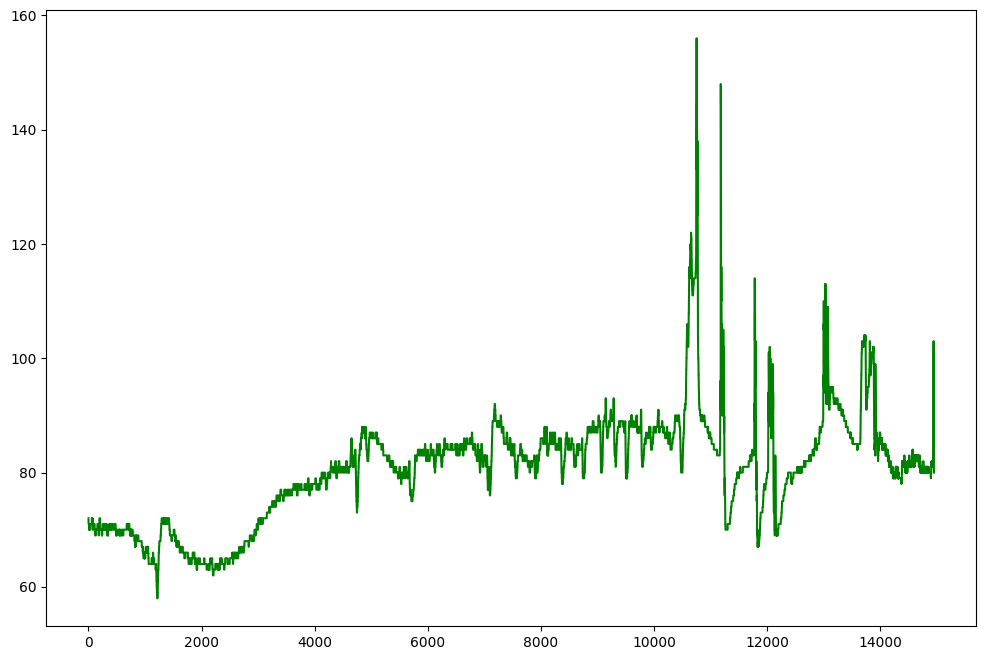

In [ ]:
plt.figure(figsize=(12, 8))
normal_x = []  # X-coordinates for normal data
normal_y = []  # Y-coordinates for normal data

anomaly_x = []  # X-coordinates for anomalies
anomaly_y = []  # Y-coordinates for anomalies

for i, score in enumerate(test_predictions):
    if score == 1:
        # Anomaly data
        anomaly_x.append(i)
        anomaly_y.append(test_df['ABP1'].iloc[i])

        # Normal data
    normal_x.append(i)
    normal_y.append(test_df['ABP1'].iloc[i])
plt.plot(normal_x, normal_y, color='g', label='Normal')

# Plot anomalies as a red line
plt.scatter(anomaly_x, anomaly_y,marker = 'o',s=10 ,color='r', label='Anomalies')

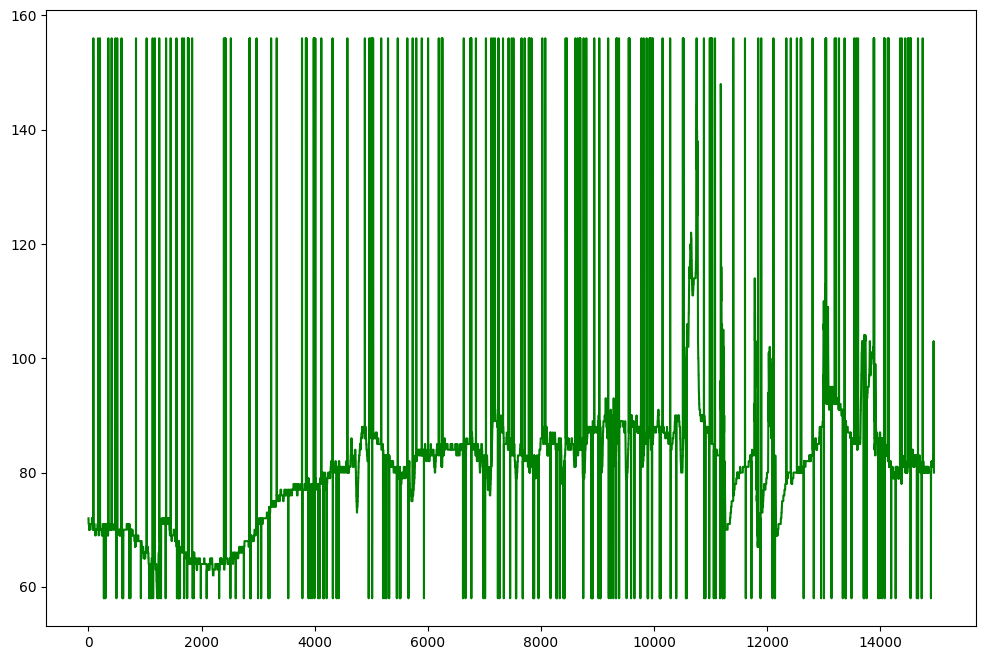

In [ ]:
plt.figure(figsize=(12, 8))
normal_x = []  # X-coordinates for normal data
normal_y = []  # Y-coordinates for normal data

anomaly_x = []  # X-coordinates for anomalies
anomaly_y = []  # Y-coordinates for anomalies

for i, score in enumerate(test_predictions_noisy):
    if score == 1:
        # Anomaly data
        anomaly_x.append(i)
        anomaly_y.append(test_df_noisy['ABP1'].iloc[i])

        # Normal data
    normal_x.append(i)
    normal_y.append(test_df_noisy['ABP1'].iloc[i])
plt.plot(normal_x, normal_y, color='g', label='Normal')

# Plot anomalies as a red line
plt.scatter(anomaly_x, anomaly_y,marker = 'o',s=10 ,color='r', label='Anomalies')


***Leveraging generator to find short term spikes***

In [ ]:
custom_shape = (60177, 16)
custom_latent = tf.random.normal(shape=custom_shape)


In [ ]:
predicted_gen = generator.predict(custom_latent)

In [ ]:
predicted_gen.shape

(60177, 128, 7)

In [ ]:
last_value_test = predicted_gen[:,-1,:]
output_data_gen_scaled = last_value_test.reshape(-1, last_value_test.shape[-1])

In [ ]:
output_data_gen_scaled

array([[1.1440325e-01, 6.7434457e-19, 1.8526109e-08, ..., 3.4850549e-03,
        9.9818403e-01, 7.5673941e-03],
       [5.6790192e-02, 1.2028046e-19, 1.5457104e-08, ..., 1.2473086e-03,
        9.9912161e-01, 9.8292576e-04],
       [8.6480223e-02, 3.9802235e-19, 1.8383762e-08, ..., 2.3530538e-03,
        9.9866867e-01, 3.2006251e-03],
       ...,
       [1.1054875e-01, 7.0886168e-19, 1.9463100e-08, ..., 3.3655902e-03,
        9.9824893e-01, 6.7412308e-03],
       [1.1529008e-01, 5.5971285e-19, 1.7076429e-08, ..., 3.4470393e-03,
        9.9822968e-01, 7.7785081e-03],
       [8.5899182e-02, 2.8229826e-19, 1.6988553e-08, ..., 2.1765782e-03,
        9.9870920e-01, 2.9026484e-03]], dtype=float32)

In [ ]:
output_data_gen= scaler_train.inverse_transform(output_data_gen_scaled)

In [ ]:
df_gen = pd.DataFrame(output_data_gen, columns =df.columns)

In [ ]:
deviation = train_df[:60177] - df_gen
deviation

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.844116,-3.069595,-2.627159,3.671183,-9.085144,-26.760437,-6.529675
1,1.019676,-3.069595,-2.627159,3.671183,-9.057930,-26.780182,-6.476440
2,0.929207,-3.069595,-2.627159,1.671183,-8.071381,-26.770645,-5.494370
3,0.798531,-3.069595,-2.627159,1.671183,-9.096977,-26.747437,-5.560612
4,0.999977,-3.069595,-2.627159,1.671183,-9.059319,-26.778870,-6.478092
...,...,...,...,...,...,...,...
60172,-8.202309,-8.069595,-8.627159,-0.328817,-6.095955,-31.751831,-5.563221
60173,-8.198456,-8.069595,-8.627159,-0.328817,-7.098808,-32.742233,-5.557068
60174,-8.144135,-8.069595,-8.627159,-0.328817,-7.083687,-32.761795,-5.522995
60175,-8.158585,-8.069595,-8.627159,0.671183,-7.084679,-32.761398,-5.531384


In [ ]:
rolling_mean = deviation.rolling( window = 100 ).mean()
deviation_df = deviation.sub(rolling_mean.shift(), fill_value=0)

In [ ]:
deviation_df

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.844116,-3.069595,-2.627159,3.671183,-9.085144,-26.760437,-6.529675
1,1.019676,-3.069595,-2.627159,3.671183,-9.057930,-26.780182,-6.476440
2,0.929207,-3.069595,-2.627159,1.671183,-8.071381,-26.770645,-5.494370
3,0.798531,-3.069595,-2.627159,1.671183,-9.096977,-26.747437,-5.560612
4,0.999977,-3.069595,-2.627159,1.671183,-9.059319,-26.778870,-6.478092
...,...,...,...,...,...,...,...
60172,-0.018065,-0.340000,-0.850000,-0.710000,0.329621,0.114997,-0.181430
60173,-0.003746,-0.340000,-0.840000,-0.700000,-0.673085,-0.865513,-0.164911
60174,0.061321,-0.340000,-0.830000,-0.690000,-0.647763,-0.865308,-0.120400
60175,0.046422,-0.340000,-0.820000,0.320000,-0.638836,-0.844839,-0.129079


In [ ]:
mean_deviation = deviation_df.sum(axis=0)/len(deviation_df)
print(mean_deviation)

SpO2    -0.005914
HR      -0.007521
PULSE   -0.007748
RESP     0.000428
ABP1    -0.007494
ABP2    -0.041813
ABP3    -0.006529
dtype: float64


In [ ]:
absolute_diff = deviation_df.apply(lambda row: abs(row - mean_deviation), axis=1)
print(absolute_diff)

           SpO2        HR     PULSE      RESP      ABP1       ABP2      ABP3
0      0.850030  3.062075  2.619411  3.670754  9.077650  26.718624  6.523145
1      1.025590  3.062075  2.619411  3.670754  9.050436  26.738369  6.469911
2      0.935121  3.062075  2.619411  1.670754  8.063887  26.728832  5.487840
3      0.804445  3.062075  2.619411  1.670754  9.089484  26.705624  5.554082
4      1.005891  3.062075  2.619411  1.670754  9.051825  26.737057  6.471563
...         ...       ...       ...       ...       ...        ...       ...
60172  0.012151  0.332479  0.842252  0.710428  0.337115   0.156810  0.174901
60173  0.002168  0.332479  0.832252  0.700428  0.665592   0.823700  0.158381
60174  0.067235  0.332479  0.822252  0.690428  0.640269   0.823495  0.113871
60175  0.052336  0.332479  0.812252  0.319572  0.631342   0.803026  0.122550
60176  0.142535  0.332479  0.802252  0.309572  0.605792   0.793192  0.082852

[60177 rows x 7 columns]


In [ ]:
standard_deviation_df = deviation_df.apply(lambda row: (row - mean_deviation)**2, axis=1)
print(standard_deviation_df)

           SpO2        HR     PULSE       RESP       ABP1        ABP2  \
0      0.722552  9.376301  6.861315  13.474438  82.403737  713.884873   
1      1.051836  9.376301  6.861315  13.474438  81.910398  714.940375   
2      0.874451  9.376301  6.861315   2.791420  65.026273  714.430472   
3      0.647131  9.376301  6.861315   2.791420  82.618712  713.190332   
4      1.011817  9.376301  6.861315   2.791420  81.935534  714.870202   
...         ...       ...       ...        ...        ...         ...   
60172  0.000148  0.110543  0.709389   0.504708   0.113646    0.024589   
60173  0.000005  0.110543  0.692644   0.490600   0.443012    0.678482   
60174  0.004521  0.110543  0.676099   0.476691   0.409945    0.678144   
60175  0.002739  0.110543  0.659753   0.102126   0.398593    0.644851   
60176  0.020316  0.110543  0.643608   0.095835   0.366984    0.629154   

            ABP3  
0      42.551421  
1      41.859748  
2      30.116388  
3      30.847829  
4      41.881124  
...      

In [ ]:
standard_deviation = np.sqrt(standard_deviation_df.sum(axis=0)/len(standard_deviation_df))
print(standard_deviation)

SpO2     1.120562
HR       1.351114
PULSE    2.685080
RESP     2.296829
ABP1     2.936414
ABP2     4.000682
ABP3     2.356543
dtype: float64


In [ ]:
Anomaly_score = absolute_diff/standard_deviation

In [ ]:
Anomaly_score

,SpO2,HR,PULSE,RESP,ABP1,ABP2,ABP3
0,0.758575,2.266333,0.975543,1.598184,3.091407,6.678518,2.768100
1,0.915246,2.266333,0.975543,1.598184,3.082140,6.683454,2.745510
2,0.834511,2.266333,0.975543,0.727418,2.746169,6.681070,2.328768
3,0.717894,2.266333,0.975543,0.727418,3.095437,6.675269,2.356878
4,0.897667,2.266333,0.975543,0.727418,3.082612,6.683126,2.746211
...,...,...,...,...,...,...,...
60172,0.010844,0.246078,0.313679,0.309308,0.114805,0.039196,0.074219
60173,0.001935,0.246078,0.309954,0.304954,0.226668,0.205890,0.067209
60174,0.060001,0.246078,0.306230,0.300601,0.218045,0.205839,0.048321
60175,0.046705,0.246078,0.302506,0.139136,0.215005,0.200722,0.052004


In [ ]:
greater_than_array = Anomaly_score.gt(standard_deviation)

# Add a new column with 1 if the value is greater than the array value, 0 otherwise
Anomaly_score['Anomaly'] = greater_than_array.any(axis=1).astype(int)

In [ ]:
anomaly_array = Anomaly_score['Anomaly'].values

In [ ]:
total_ones = anomaly_array.count(1)
total_ones

AttributeError: 'numpy.ndarray' object has no attribute 'count'

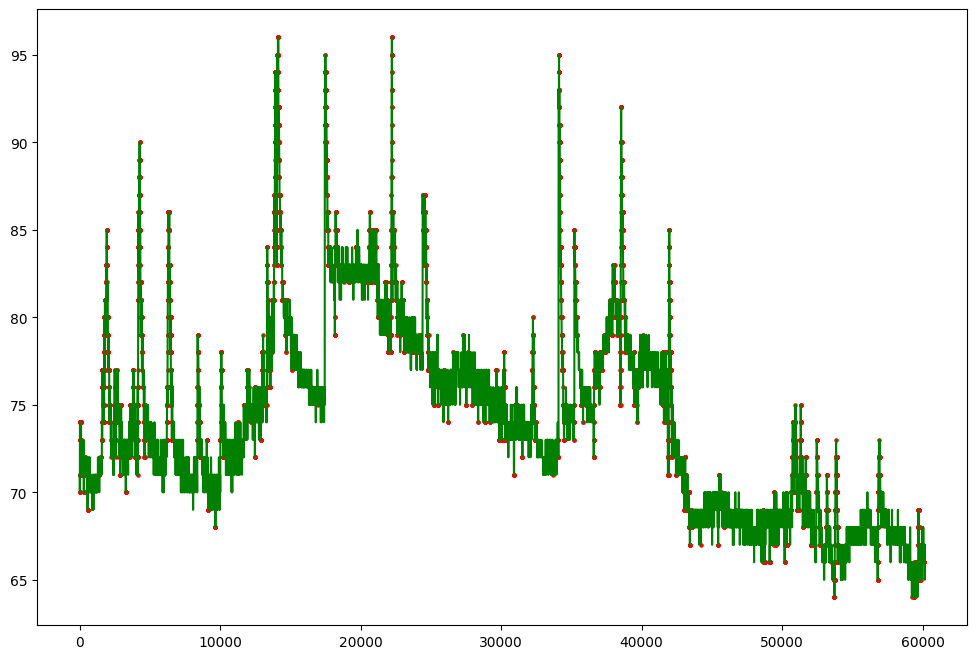

In [ ]:
plt.figure(figsize=(12, 8))
normal_x = []  # X-coordinates for normal data
normal_y = []  # Y-coordinates for normal data

anomaly_x = []  # X-coordinates for anomalies
anomaly_y = []  # Y-coordinates for anomalies

for i, score in enumerate(anomaly_array):
    if score == 1:
        # Anomaly data
        anomaly_x.append(i)
        anomaly_y.append(train_df['HR'].iloc[i])

        # Normal data
    normal_x.append(i)
    normal_y.append(train_df['HR'].iloc[i])
plt.plot(normal_x, normal_y, color='g', label='Normal')

# Plot anomalies as a red line
plt.scatter(anomaly_x, anomaly_y,marker = 'o',s=5 ,color='r', label='Anomalies')